In [1]:
import pandas as pd
import numpy as np
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json

import minio_communication
from transform import *

In [2]:
def get_seats_dict(df, name_sep=','):
    seats_dict = {}
    for x in df.to_dict(orient="records"):
        name = x['party,seats'].split(name_sep)[0].strip()
        seats_dict[name] = int(x['party,seats'].split(',')[1].strip())
    return seats_dict

def ccn(n):
    n = n.split('WYBORCZY')[1].strip()
    if 'WYBORCÓW' in n:
        n = n.split('WYBORCÓW')[1].strip()
    n = n.split('-')[0].strip()
    return n

def plots_from_seats(seats_2019, seats_2023, label):
    colors = list(mcolors.TABLEAU_COLORS.keys())
    if len(colors) <= len(seats_2019):
        colors = list(mcolors.CSS4_COLORS.keys())
        np.random.shuffle(colors)        

    color_dict = {}
    for i, (_, sd) in enumerate([(2019, seats_2019), (2023, seats_2023)]):
        for x, y in sd:
            if x not in color_dict:
                color_dict[x] = colors.pop(0)
    
    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    for i, (year, sd) in enumerate([(2019, seats_2019), (2023, seats_2023)]):
        colors = [color_dict[x] for x, _ in sd]
        ax[i].bar([x for x, _ in sd], [y for _, y in sd], color=colors, label=[x for x, _ in sd])
        ax[i].set_xticks(["" for _ in sd])
        ax[i].set_title(f"{year} {label}")
        ax[i].set_xlabel("Partia")
        ax[i].set_ylabel("Mandaty")
        ax[i].axhline(230, color='black', linestyle='--')
        for x, y in sd:
            ax[i].annotate(y, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

    plt.show()

In [3]:
client = minio_communication.get_client()

minio_2019_config = minio_communication.get_minio_bucket_configuration(2019)
minio_2023_config = minio_communication.get_minio_bucket_configuration(2023)

districts_2019 = load_districts(client, minio_2019_config, 2019)
districts_2023 = load_districts(client, minio_2023_config, 2023)
districts_2019.index += 1
districts_2023.index += 1


results_2019 = load_results(client, minio_2019_config, 2019)
results_2023 = load_results(client, minio_2023_config, 2023)

seats = {}
info = {}
for year, config in [(2019, minio_2019_config), (2023, minio_2023_config)]:
    seats[year] = {}
    info[year] = {}
    for cls in Apportionment.__subclasses__() + [ConstituencialDHondtNoThreshold, ConstituencialSainteLagueNoThreshold]:
        obj = seats_obj_name(cls)
        info_obj = additional_info_obj_name(cls)
        resp = client.get_object(config.transformed_data_bucket, obj)
        seats[year][cls.name()] = pd.read_csv(BytesIO(resp.read()), sep=";")
        resp = client.get_object(config.transformed_data_bucket, info_obj)
        info[year][cls.name()] = json.loads(resp.read())

# Apportionment Systems Comparison 
### Based on the 2019 and 2023 Polish Parliamentary Elections

This notebook compares the results of the 2019 and 2023 Polish Parliamentary Elections using different apportionment systems. The results of the elections are based on the official results published by the National Electoral Commission (PKW).

#### Districts
The chagnes between 2019 and 2023 are neglibile.

In [4]:
print("2019 Totals:")
districts_2019[['Liczba mandatów', "Liczba kandydatów", "Mieszkańcy", "Wyborcy"]].sum(axis=0, numeric_only=True)

2019 Totals:


Liczba mandatów           460
Liczba kandydatów        5111
Mieszkańcy           36910074
Wyborcy              30071458
dtype: int64

In [5]:
print("2023 Totals:")
districts_2023[['Liczba mandatów', "Liczba kandydatów", "Mieszkańcy", "Wyborcy"]].sum(axis=0, numeric_only=True)

2023 Totals:


Liczba mandatów           460
Liczba kandydatów        6333
Mieszkańcy           35858930
Wyborcy              29091621
dtype: int64

In [6]:
districts_2019["Procent mieszkańców"] = 100 * districts_2019["Mieszkańcy"] / districts_2019["Mieszkańcy"].sum()
districts_2019["Procent wyborców"] = 100 * districts_2019["Wyborcy"] / districts_2019["Wyborcy"].sum()
districts_2019["Procent mandatów"] = 100 * districts_2019["Liczba mandatów"] / districts_2019["Liczba mandatów"].sum()

columns = ["Siedziba OKW", "Mieszkańcy", "Wyborcy", "Liczba mandatów", "Procent mieszkańców", "Procent wyborców", "Procent mandatów"]

In [7]:
print("Biggest districts by population:")
districts_2019.sort_values(by="Mieszkańcy", ascending=False).head(10)[columns]

Biggest districts by population:


,Siedziba OKW,Mieszkańcy,Wyborcy,Liczba mandatów,Procent mieszkańców,Procent wyborców,Procent mandatów
19,Warszawa,1674506,1701541,20,4.536718,5.658326,4.347826
23,Rzeszów,1241140,984494,15,3.362605,3.273849,3.260870
33,Kielce,1222607,997692,16,3.312394,3.317737,3.478261
3,Wrocław,1201333,993744,14,3.254756,3.304609,3.043478
26,Słupsk,1191547,928375,14,3.228243,3.087230,3.043478
6,Lublin,1162325,934842,15,3.149073,3.108735,3.260870
24,Białystok,1146820,919130,14,3.107065,3.056486,3.043478
13,Kraków,1142182,942910,14,3.094499,3.135565,3.043478
20,Warszawa,1088736,850607,12,2.949699,2.828619,2.608696
25,Gdańsk,1019416,823001,12,2.761891,2.736818,2.608696


In [8]:
print("Biggest districts by voters:")
districts_2019.sort_values(by="Wyborcy", ascending=False).head(10)[columns]

Biggest districts by voters:


,Siedziba OKW,Mieszkańcy,Wyborcy,Liczba mandatów,Procent mieszkańców,Procent wyborców,Procent mandatów
19,Warszawa,1674506,1701541,20,4.536718,5.658326,4.347826
33,Kielce,1222607,997692,16,3.312394,3.317737,3.478261
3,Wrocław,1201333,993744,14,3.254756,3.304609,3.043478
23,Rzeszów,1241140,984494,15,3.362605,3.273849,3.260870
13,Kraków,1142182,942910,14,3.094499,3.135565,3.043478
6,Lublin,1162325,934842,15,3.149073,3.108735,3.260870
26,Słupsk,1191547,928375,14,3.228243,3.087230,3.043478
24,Białystok,1146820,919130,14,3.107065,3.056486,3.043478
20,Warszawa,1088736,850607,12,2.949699,2.828619,2.608696
25,Gdańsk,1019416,823001,12,2.761891,2.736818,2.608696


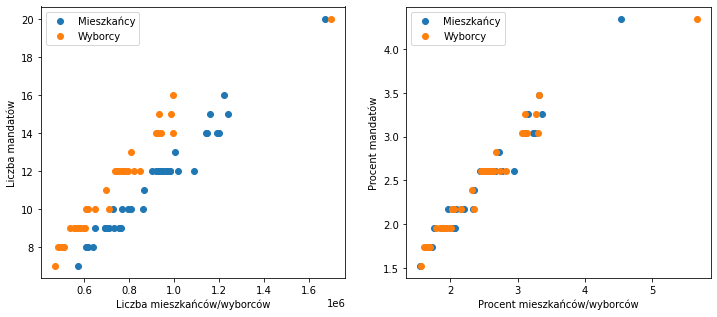

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(districts_2019["Mieszkańcy"], districts_2019["Liczba mandatów"], label="Mieszkańcy")
ax[0].scatter(districts_2019["Wyborcy"], districts_2019["Liczba mandatów"], label="Wyborcy")
ax[0].set_xlabel("Liczba mieszkańców/wyborców")
ax[0].set_ylabel("Liczba mandatów")
ax[0].legend()

ax[1].scatter(districts_2019["Procent mieszkańców"], districts_2019["Procent mandatów"], label="Mieszkańcy")
ax[1].scatter(districts_2019["Procent wyborców"], districts_2019["Procent mandatów"], label="Wyborcy")
ax[1].set_xlabel("Procent mieszkańców/wyborców")
ax[1].set_ylabel("Procent mandatów")
ax[1].legend()

plt.show()

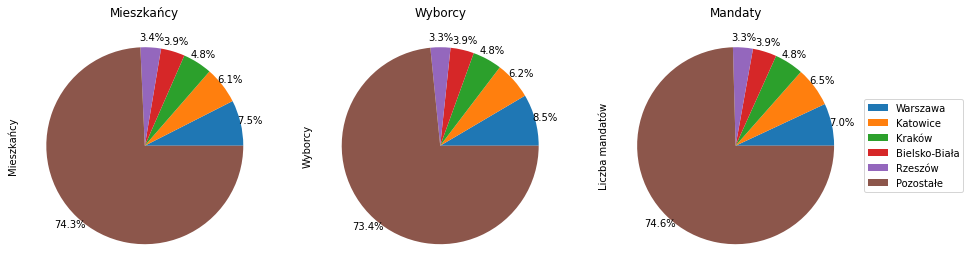

In [10]:
aggregated = districts_2019.groupby("Siedziba OKW").sum()

biggest_districts = aggregated.sort_values(by="Mieszkańcy", ascending=False).head(5)

rest = aggregated.sort_values(by="Mieszkańcy", ascending=False).tail(aggregated.shape[0] - 5).sum(axis=0)

biggest_districts.loc["Pozostałe"] = rest

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

biggest_districts["Mieszkańcy"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Mieszkańcy", ax=ax[0])
biggest_districts["Wyborcy"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Wyborcy", ax=ax[1])
biggest_districts["Liczba mandatów"].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="Mandaty", ax=ax[2])

ax[2].legend(labels=biggest_districts.index, loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()


#### Voting Results

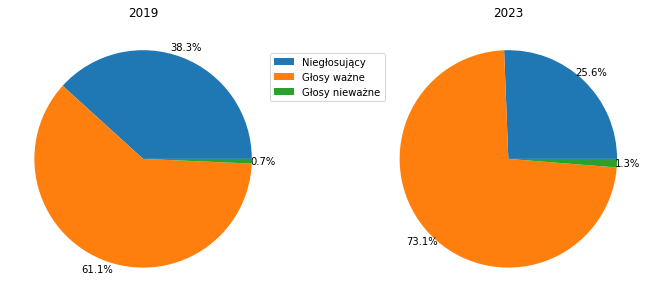

In [11]:
cols = [
    "Liczba wyborców uprawnionych do głosowania ale nie głosujących",
    "Liczba głosów ważnych oddanych łącznie na wszystkie listy kandydatów",
    "Liczba głosów nieważnych"
]

agg_2019 = results_2019.sum(axis=0, numeric_only=True)
agg_2023 = results_2023.sum(axis=0, numeric_only=True)

up = "Liczba wyborców uprawnionych do głosowania ale nie głosujących"
agg_2019[cols[0]] = agg_2019["Liczba wyborców uprawnionych do głosowania"] - agg_2019[cols[1]] - agg_2019[cols[2]]
agg_2023[cols[0]] = agg_2023["Liczba wyborców uprawnionych do głosowania"] - agg_2023[cols[1]] - agg_2023[cols[2]]


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

agg_2019[cols].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="2019", ax=ax[0])

agg_2023[cols].plot.pie(autopct='%1.1f%%', pctdistance=1.1, labels=None, title="2023", ax=ax[1])

ax[0].legend(labels=["Niegłosujący", "Głosy ważne", "Głosy nieważne"], loc="center left", bbox_to_anchor=(0.95, 0.8))

plt.show()

# Issues

* Voters moving between constituencies
* 2011 Census 
* Varying attendance 

# Consequences -> Unfair system 
Elblag 299'380 -> 8 seats  \
Chełm 456'872 -> 12 seats \
Razem 756'252 -> 20 seats \
vs \
Warszawa 1'714'719 -> 20 seats


2019:
KOMITET WYBORCZY PRAWO I SPRAWIEDLIWOŚĆ - ZPOW-601-9/19                               8051935.0
KOALICYJNY KOMITET WYBORCZY KOALICJA OBYWATELSKA PO .N IPL ZIELONI - ZPOW-601-6/19    5060355.0
KOMITET WYBORCZY POLSKIE STRONNICTWO LUDOWE - ZPOW-601-19/19                          2319946.0
KOMITET WYBORCZY SOJUSZ LEWICY DEMOKRATYCZNEJ - ZPOW-601-1/19                         1578523.0
KOMITET WYBORCZY KONFEDERACJA WOLNOŚĆ I NIEPODLEGŁOŚĆ - ZPOW-601-5/19                 1256953.0
KOMITET WYBORCZY WYBORCÓW KOALICJA BEZPARTYJNI I SAMORZĄDOWCY - ZPOW-601-10/19         144773.0
KOMITET WYBORCZY WYBORCÓW MNIEJSZOŚĆ NIEMIECKA - ZPOW-601-15/19                         32094.0
KOMITET WYBORCZY SKUTECZNI PIOTRA LIROYA-MARCA - ZPOW-601-17/19                         18918.0
KOMITET WYBORCZY AKCJA ZAWIEDZIONYCH EMERYTÓW RENCISTÓW - ZPOW-601-21/19                 5448.0
KOMITET WYBORCZY PRAWICA - ZPOW-601-20/19                                                1765.0
dtype: float64

2023:
KOMITET WYBO

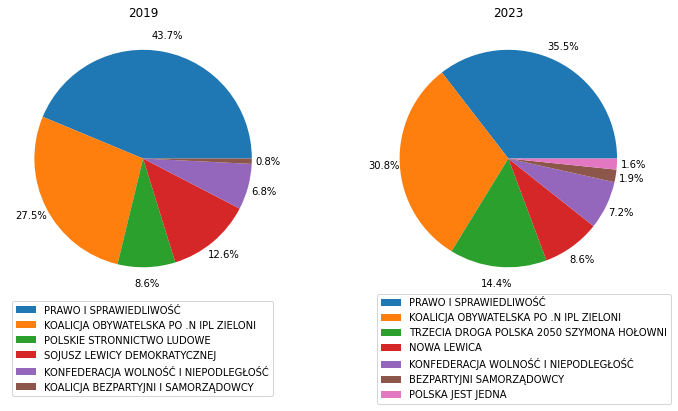

In [12]:
agg_2019 = results_2019.sum(axis=0, numeric_only=True)
agg_2023 = results_2023.sum(axis=0, numeric_only=True)

parties_2019 = agg_2019.filter(regex="KOMITET")
parties_2023 = agg_2023.filter(regex="KOMITET")
parties_2019 = parties_2019.sort_values(ascending=False)
parties_2019.iloc[2], parties_2019.iloc[3] = parties_2019.iloc[3], parties_2019.iloc[2]
parties_2023 = parties_2023.sort_values(ascending=False)

print("2019:")
print(parties_2019.sort_values(ascending=False))
print("\n2023:")
print(parties_2023.sort_values(ascending=False))

parties_2019 = parties_2019[parties_2019 > 100000]
parties_2023 = parties_2023[parties_2023 > 100000]

lst = parties_2019.index.map(ccn).tolist()
lst[2],lst[3] = lst[3],lst[2]
parties_2019.index = lst

parties_2023.index = parties_2023.index.map(ccn)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

parties_2019.plot.pie(autopct='%1.1f%%', pctdistance=1.15, labels=None, title="2019", ax=ax[0])
parties_2023.plot.pie(autopct='%1.1f%%', pctdistance=1.15, labels=None, title="2023", ax=ax[1])

ax[0].legend(labels=parties_2019.index, loc="center left", bbox_to_anchor=(0, -0.2))
ax[1].legend(labels=parties_2023.index, loc="center left", bbox_to_anchor=(0, -0.2))

plt.show()

## Pipeline Description

The pipeline consists of the following steps:
1. Data loading -- Given the official results we download the data and store it in Minio.
2. Data processing -- We process the data and store it in Minio.
3. Results visualization -- By connecting with minio we visualize the results inside this notebook

What is worth noting, is that steps 1 and 2 are fully automated and can be easily
reused for other elections and extended for other systems.

We achieve that by separating the stages of the pipeline into separate programs that just 
need to ensure that the data is stored in the correct format at the end of each stage
and by using the class system that allows us to add new apportionment systems without
changing the code of the pipeline.

## Methods

We compare the results of the elections using the two most popular apportionment systems: the [D'Hondt method](https://en.wikipedia.org/wiki/D%27Hondt_method) and the [Sainte-Laguë method](https://en.wikipedia.org/wiki/Webster/Sainte-Lagu%C3%AB_method),
their regional and globale variants, together with the default thresholds and without them.

Additionally we compare them with two other apportionment systems proposed by Grzegorz:

* Square D'Hondt method
* Fair Vote Weight D'Hondt method


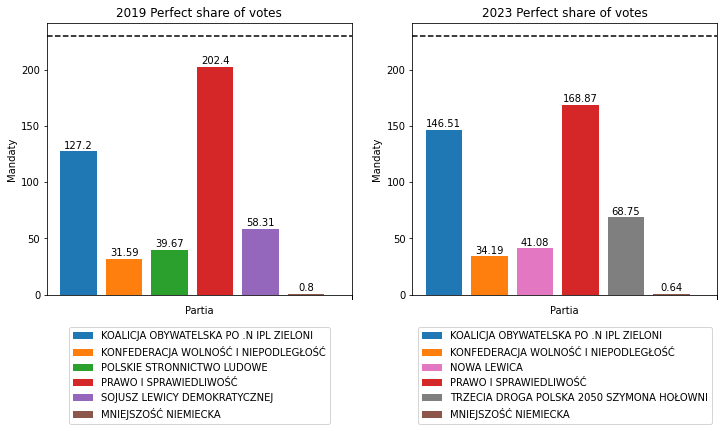

In [13]:
SEATS = 460 
THRESHOLD = 0.05
seats_2019 = {}
seats_2023 = {}

parties_2019 = agg_2019.filter(regex="KOMITET")
parties_2023 = agg_2023.filter(regex="KOMITET")

mn2019 = list(dict(agg_2019.filter(regex="MNIEJSZOŚĆ")).items())
mn2023 = list(dict(agg_2023.filter(regex="MNIEJSZOŚĆ")).items())

votes_2019 = parties_2019.sum()
votes_2023 = parties_2023.sum() 

parties_2019 = parties_2019[parties_2019 / votes_2019 > THRESHOLD]
parties_2023 = parties_2023[parties_2023 / votes_2023 > THRESHOLD]

votes_2019 = parties_2019.sum() + mn2019[0][1]
votes_2023 = parties_2023.sum() + mn2023[0][1]

seats_2019 = (parties_2019 / votes_2019 * SEATS)
seats_2023 = (parties_2023 / votes_2023 * SEATS)

seats_2019 = sorted([(ccn(x), int(y * 100) / 100) for x, y in seats_2019.items()])
seats_2023 = sorted([(ccn(x), int(y * 100) / 100) for x, y in seats_2023.items()])

mn2019 = ccn(mn2019[0][0]), int(mn2019[0][1] * 100 * SEATS / votes_2019) / 100 
seats_2019.append(mn2019)

mn2023 = ccn(mn2023[0][0]), int(mn2023[0][1] * 100 * SEATS / votes_2019) / 100 
seats_2023.append(mn2023)

plots_from_seats(seats_2019, seats_2023, "Perfect share of votes")

## Results

Here we present a brief graphical summary of the results that we obtained from the pipeline.

In [14]:
def present_method(method, label="D'Hondt"):
    seats_2019 = [(ccn(k), v) for k, v in get_seats_dict(seats[2019][method.name()], '-').items()]
    seats_2023 = [(ccn(k), v) for k, v in get_seats_dict(seats[2023][method.name()]).items()]

    seats_2019 = sorted(seats_2019)
    seats_2023 = sorted(seats_2023)

    plots_from_seats(seats_2019, seats_2023, label)

### Dhondt Method vs. Sainte-Lague Method

Opole District - 12 seats - 2023 results


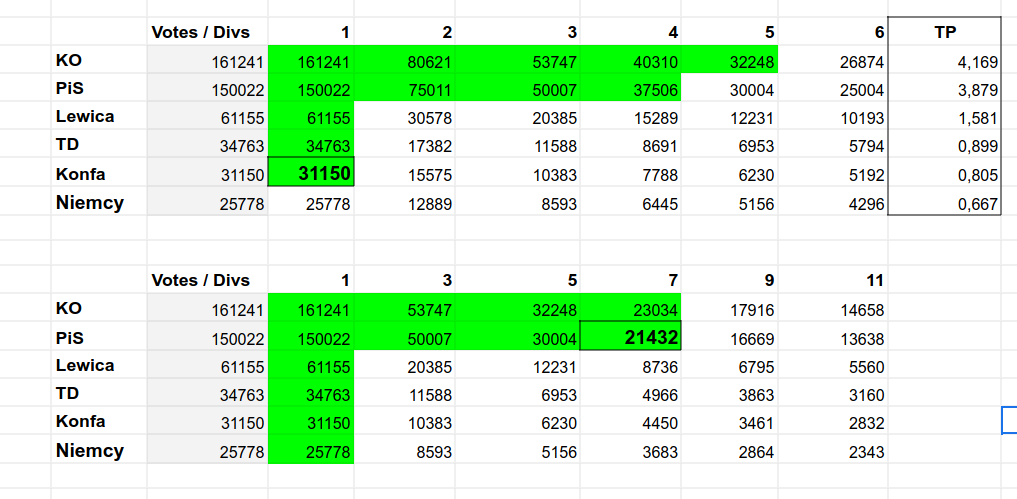

In [15]:
from IPython.display import Image
print("Opole District - 12 seats - 2023 results")
Image(filename='comparison.png')

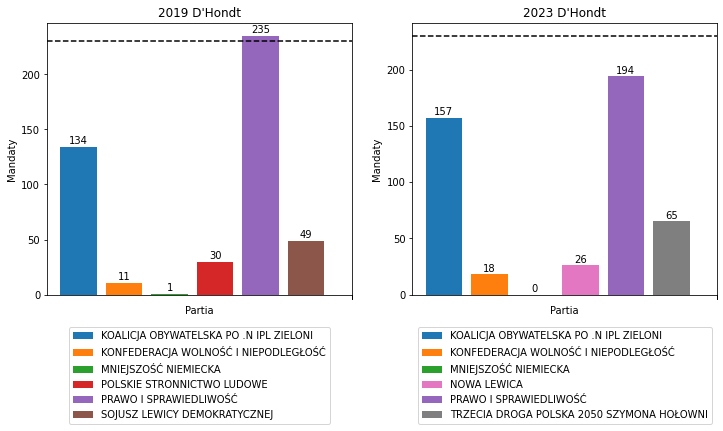

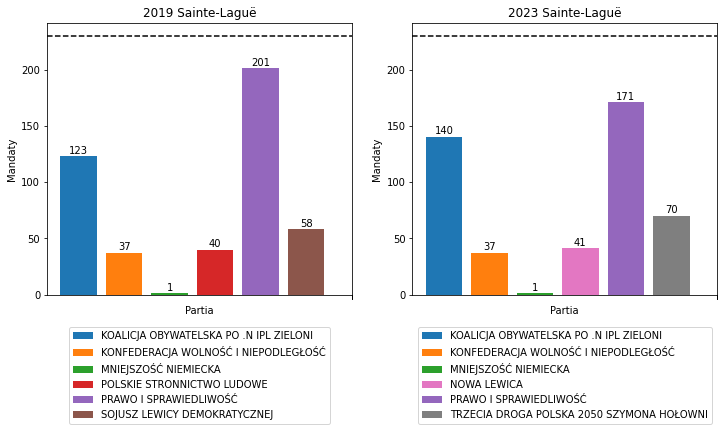

In [16]:
present_method(ConstituencialDHondt)
present_method(ConstituencialSainteLague, label="Sainte-Laguë")

### How does the global seat allocation affect the results?

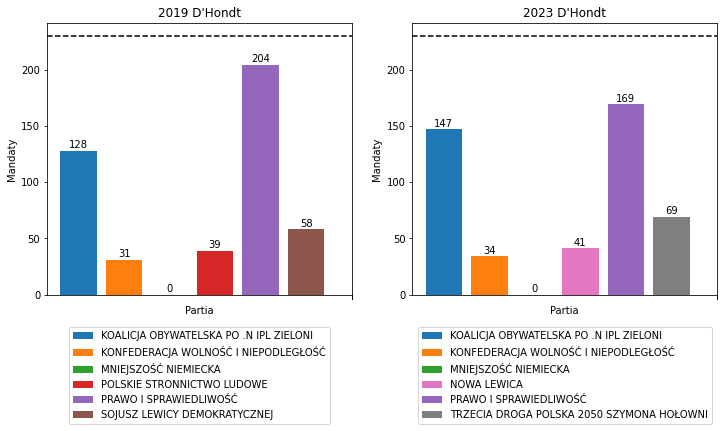

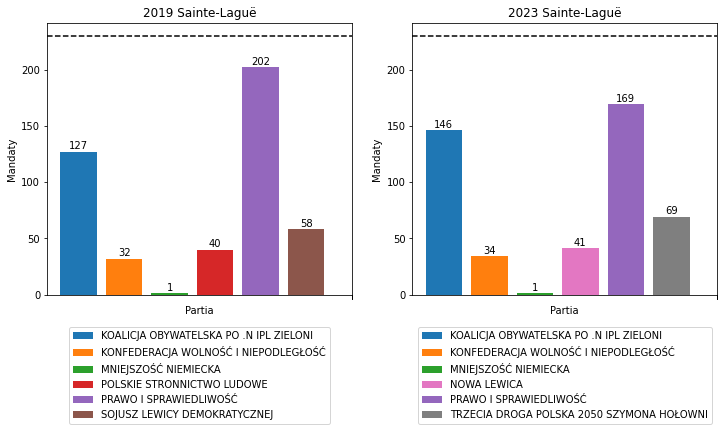

In [17]:
present_method(GlobalDHondt)
present_method(GlobalSainteLague, label="Sainte-Laguë")

### How does removing the thresholds affect the results?

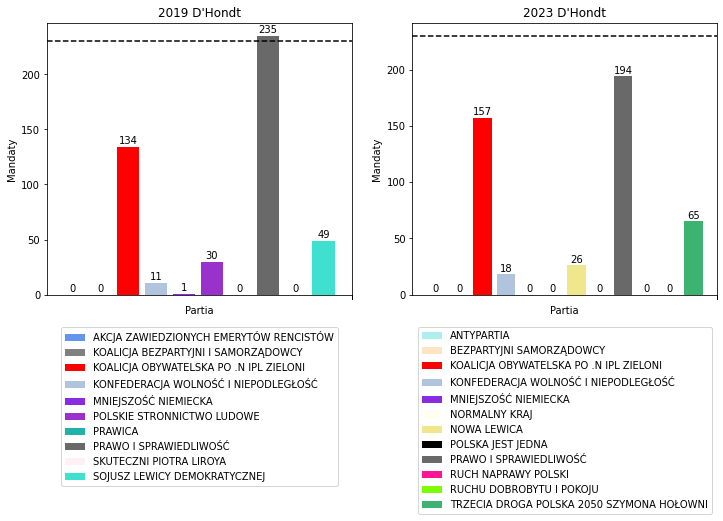

In [18]:
np.random.seed(0xDDDDDD)
present_method(ConstituencialDHondtNoThreshold)

### Squared Dhondt Method

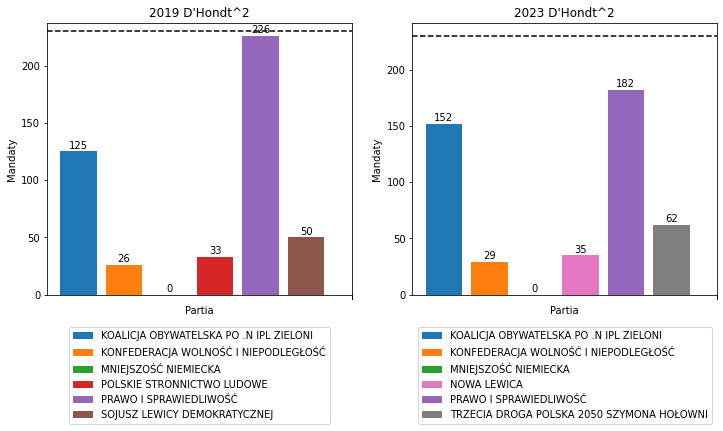

In [19]:
present_method(SquaredDHondt, "D'Hondt^2")

### Fair Vote Weight DHondt Method


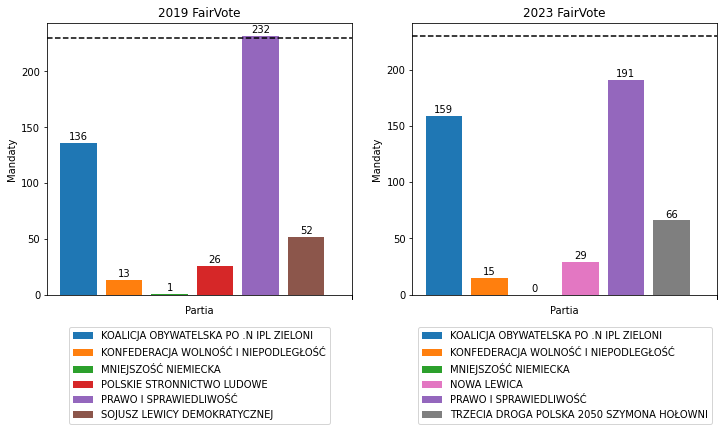

In [20]:
present_method(FairVoteWeightDHondt, "FairVote")

In [21]:
year = 2023
print(year)
cmp = info[year][FairVoteWeightDHondt.name()]['Full comparison befere']
df = pd.DataFrame.from_dict(cmp)
display(df[df.index != 'sum'])
print(info[year][FairVoteWeightDHondt.name()]['Vote Strength before'])



2023


,Siedziba OKW,Liczba mandatów,True proportion,Voter Strength
19,Warszawa,20,36.522788,-45.239667
20,Warszawa,12,15.564537,-22.901660
39,Poznań,10,12.695357,-21.231043
3,Wrocław,14,16.529621,-15.303564
13,Kraków,14,16.134897,-13.231553
25,Gdańsk,12,13.126652,-8.582934
27,Bielsko-Biała,9,9.485681,-5.120149
26,Słupsk,14,14.545459,-3.750031
37,Konin,9,8.929698,0.787281
28,Częstochowa,7,6.899806,1.452128


Voters in Elbląg have vote 2.291x as strong as voters in Warszawa


In [22]:
cmp = info[year][FairVoteWeightDHondt.name()]['Full comparison after']
df = pd.DataFrame.from_dict(cmp)
display(df[df.index != 'sum'])
print(info[year][FairVoteWeightDHondt.name()]['Vote Strength after'])
print('\n' + '=============' * 7 + '\n')

,Siedziba OKW,Liczba mandatów,True proportion,Voter Strength
34,Elbląg,6,6.376667,-5.906958
10,Piotrków Trybunalski,8,8.452076,-5.348703
27,Bielsko-Biała,9,9.485681,-5.120149
16,Płock,9,9.426489,-4.524372
22,Krosno,9,9.414327,-4.401030
17,Radom,8,8.332437,-3.989670
35,Olsztyn,8,8.329370,-3.954316
5,Toruń,11,11.450588,-3.935066
4,Bydgoszcz,11,11.372248,-3.273305
11,Sieradz,11,11.355400,-3.129792


Voters in Tarnów have vote 1.1127x as strong as voters in Elbląg




In [23]:
year = 2019
print(year)
cmp = info[year][FairVoteWeightDHondt.name()]['Full comparison befere']
df = pd.DataFrame.from_dict(cmp)
display(df[df.index != 'sum'])
print(info[year][FairVoteWeightDHondt.name()]['Vote Strength before'])


2019


,Siedziba OKW,Liczba mandatów,True proportion,Voter Strength
19,Warszawa,20,34.415668,-41.886933
39,Poznań,10,12.813932,-21.959941
20,Warszawa,12,14.910873,-19.521817
3,Wrocław,14,16.298740,-14.103790
13,Kraków,14,16.170035,-13.420099
25,Gdańsk,12,13.170113,-8.884609
27,Bielsko-Biała,9,9.694146,-7.160466
9,Łódź,10,10.348731,-3.369790
26,Słupsk,14,14.462472,-3.197736
28,Częstochowa,7,7.085695,-1.209410


Voters in Elbląg have vote 2.2038x as strong as voters in Warszawa


In [24]:
cmp = info[year][FairVoteWeightDHondt.name()]['Full comparison after']
df = pd.DataFrame.from_dict(cmp)
display(df[df.index != 'sum'])
print(info[year][FairVoteWeightDHondt.name()]['Vote Strength after'])
print('\n' + '=============' * 7 + '\n')

,Siedziba OKW,Liczba mandatów,True proportion,Voter Strength
32,Katowice,8,8.353672,-4.233735
17,Radom,8,8.343163,-4.113102
4,Bydgoszcz,11,11.455527,-3.976484
34,Elbląg,6,6.246470,-3.945752
36,Kalisz,11,11.434857,-3.802904
30,Bielsko-Biała,8,8.313950,-3.776184
9,Łódź,10,10.348731,-3.369790
35,Olsztyn,8,8.260356,-3.151874
16,Płock,9,9.228560,-2.476662
18,Siedlce,11,11.279304,-2.476255


Voters in Katowice have vote 1.1078x as strong as voters in Katowice




# Extra feature 
System provides information on the last seat and difference needed to change the allocation. <br>
It was decided was not display it on the presenation not to overload viewers with data. <br>
10 different methods * 2 elections data * up to 41 constituencies = 820 extra remarks 